In [47]:
import os
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from moviepy.editor import *
from collections import deque

For the purpose of the testing, let's hide an entire video from the training ! <br>
(Remove the clips extracted from that video as well)<br>
    
    -> Do not touch folder "For_Testing"

##### Preprocess the Data <br>
Extract, Merge, Resize and Normalize <br>
*Keep the Data Augmentation for the improved model ?*

In [2]:
data_dir_path = '../cali_merl_project/data/'
labels_list = ['Inspect_Shelf', 'Inspect_Product', 'Hand_in_Shelf', 'Reach_to_Shelf', 'Retract_from_Shelf']

###### Let's research the process !

In [3]:
clip_list = os.listdir(data_dir_path + labels_list[0])
selected_clip = random.choice(clip_list)

video_reader = cv2.VideoCapture(data_dir_path + labels_list[0] + '/' + selected_clip)

success, frame = video_reader.read()

In [4]:
# Shape ?
frame.shape

(680, 920, 3)

**Notes** <br>
- 3 channels ! Only 1, make the model stronger & (Computationally cheaper) ! -> **Reshape it ?**
- Resize every frames (Computationally cheaper)

In [ ]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
gray_frame.shape

In [5]:
# Resize Frames
resized_frame = cv2.resize(frame, (64, 64))
resized_frame.shape

(64, 64, 3)

In [6]:
# Between 0 and 1 ? If no -> Normalize them !
np.min(resized_frame), np.max(resized_frame)

(0, 255)

In [7]:
# Normalize
normalized_frame = resized_frame / 255

In [8]:
np.min(normalized_frame), np.max(normalized_frame)

(0.0, 1.0)

In [9]:
normalized_frame.shape

(64, 64, 3)

In [ ]:
# Reshape with 1 channel
normalized_frame = normalized_frame.reshape(len(normalized_frame[0]),len(normalized_frame[1]),1)
normalized_frame.shape

###### Pack the process into a function

In [10]:
img_height, img_width = 64, 64
max_img_per_labels = 10000 # <- Otherwise we have to work with 330942 frames... WAY TOO MUCH

In [11]:
# Extract every frames of a clip and store it in a list !
def extract_frames(video_path):
    
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read() 

        if not success:
            break
            
        #gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resized_frame / 255
        #reshaped_frame = normalized_frame.reshape(len(normalized_frame[0]),len(normalized_frame[1]),1)
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [12]:
# Loop through all the clip to merge every frames togethere w/ labels!
def dataset():

    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the folders mentioned in the labels_list
    for label_index, label_name in enumerate(labels_list):
        print(f'Extracting all Clips of : {label_name}')
        
        files_list = os.listdir(os.path.join(data_dir_path, label_name))
        files_list.remove('.DS_Store')
        #files_list = files_list[:100]
        for file_name in files_list:
            clip_file_path = os.path.join(data_dir_path, label_name, file_name)
            
            frames = extract_frames(clip_file_path)

            temp_features.extend(frames)
        
        features.extend(random.sample(temp_features, max_img_per_labels))
        #features.extend(temp_features)
        #labels.extend([label_index] * len(temp_features))
        labels.extend([label_index] * max_img_per_labels)
        
        temp_features.clear()

    # Converting the features and labels to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [13]:
features, labels = dataset()

Extracting all Clips of : Inspect_Shelf
Extracting all Clips of : Inspect_Product
Extracting all Clips of : Hand_in_Shelf
Extracting all Clips of : Reach_to_Shelf
Extracting all Clips of : Retract_from_Shelf


In [14]:
features.shape

(50000, 64, 64, 3)

In [15]:
labels.shape

(50000,)

In [16]:
# One Hot Encode y
ohe_labels = to_categorical(labels)

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, ohe_labels, test_size = 0.3, stratify = ohe_labels)


###### Basic Modelling

In [ ]:
def initialize_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3,3), input_shape=(img_height, img_width, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    ### Flattening
    model.add(layers.Flatten())
    ### One fully connected
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(3, activation='softmax'))
    
    #opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.3)
    adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=adam,
                  metrics=['accuracy'])

    return model

In [ ]:
model = initialize_model()
model.summary()

In [ ]:
model = initialize_model()
es = EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    shuffle = True,
                    validation_split=0.3,
                    epochs=50,
                    batch_size=16, 
                    verbose=1,
                    callbacks=[es])

In [ ]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [ ]:
plot_loss_accuracy(history)

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    model = VGG16(include_top=False, weights='imagenet',
                input_shape=(64, 64, 3)
                  )
    return model

model = load_model()

In [19]:
def set_nontrainable_layers(model):
    model.trainable=False
    return model

In [20]:
def add_last_layers(model):
    base_model = set_nontrainable_layers(model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(5, activation='softmax')

    model = models.Sequential([
        base_model,
        flattening_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [30]:
def compile_model(model):
    adam_opt = optimizers.Adam(learning_rate=0.0001)

    model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])
    return model

model = compile_model(model)

In [31]:
def build_model():
    model = load_model()
    model = add_last_layers(model)
    model = compile_model(model)

    return model

model = build_model()

In [32]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 500)               1024500   
                                                                 
 dense_11 (Dense)            (None, 5)                 2505      
                                                                 
Total params: 15,741,693
Trainable params: 1,027,005
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
es = EarlyStopping(patience=20,  restore_best_weights=True)

model = build_model()

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=50,
                    batch_size=30, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/50
1532/1532 [==============================] - 1087s 709ms/step - loss: 1.4249 - accuracy: 0.3723 - val_loss: 1.3441 - val_accuracy: 0.4156
Epoch 2/50
1532/1532 [==============================] - 1179s 769ms/step - loss: 1.3301 - accuracy: 0.4299 - val_loss: 1.3031 - val_accuracy: 0.4343
Epoch 3/50
1532/1532 [==============================] - 1235s 806ms/step - loss: 1.2884 - accuracy: 0.4518 - val_loss: 1.2634 - val_accuracy: 0.4706
Epoch 4/50
1532/1532 [==============================] - 1230s 803ms/step - loss: 1.2545 - accuracy: 0.4683 - val_loss: 1.2414 - val_accuracy: 0.4856
Epoch 5/50
1532/1532 [==============================] - 1237s 807ms/step - loss: 1.2283 - accuracy: 0.4823 - val_loss: 1.2737 - val_accuracy: 0.4550
Epoch 6/50
1532/1532 [==============================] - 1232s 804ms/step - loss: 1.2031 - accuracy: 0.4962 - val_loss: 1.2153 - val_accuracy: 0.4906
Epoch 7/50
1532/1532 [==============================] - 1228s 802ms/step - loss: 1.1796 - accuracy: 0.5092

In [34]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 444s 946ms/step - loss: 0.8733 - accuracy: 0.6455


[0.8733279705047607, 0.6455333232879639]

In [35]:
#Save the model
model.save('VGG16___LOSS_87___ACCURACY_64.h5')

In [36]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

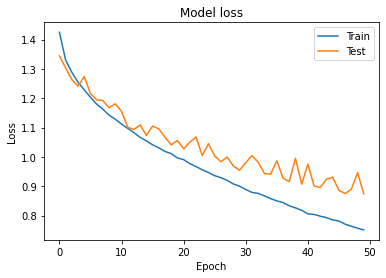

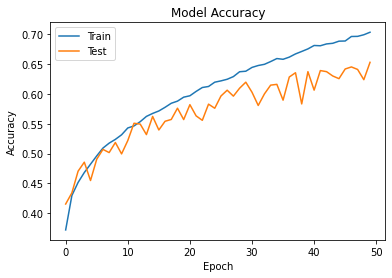

In [37]:
plot_loss_accuracy(history)

**overfitting** <br>
Should add Dropout layer!

In [65]:
def action_predict(video_file_path, output_file_path, window_size):

    predicted_labels_probabilities_deque = deque(maxlen = window_size)
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 30, (original_video_width, original_video_height))

    while True: 
        status, frame = video_reader.read() 

        if not status:
            break

        resized_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resized_frame / 255

        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Deque
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            predicted_label_name = labels_list[predicted_label]
            predict_proba = predicted_labels_probabilities_averaged[predicted_label]
            text_2_plot = f'{str(predicted_label_name)} - {str(round(predict_proba,2))} %'
          
            # Add Label on top of the clips
            x,y,w,h = 0,0,350,70
            cv2.rectangle(frame, (x, x), (x + w, y + h), (0,0,128), -1)
            cv2.putText(frame, text_2_plot, (30, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        video_writer.write(frame)

        # Do not uncomment line below otherwise JupyterNotebook Crash is coming !
        # cv2.imshow('Predicted Frames', frame)
        # key_pressed = cv2.waitKey(10)
        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [67]:
window_size = 1
video_title = '41_2_crop'
input_video_file_path = f'../cali_merl_project/For_Testing/{video_title}.mp4'
output_video_file_path = f'../cali_merl_project/predicted_vids/{video_title}_predicted.mp4'

action_predict(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
# Comment if the video is too heavy for Notebook
#VideoFileClip(output_video_file_path).ipython_display(width = 700)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
